In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_auc_score
)
from sklearn.dummy import DummyClassifier

RSEED = 42
pd.set_option('display.max_colwidth', 120)

In [ ]:
from pathlib import Path
import pandas as pd

# Membaca file dataset
fp = Path('data.csv')
raw = pd.read_csv(fp)

# Menghapus kolom yang tidak relevan (seperti 'id' atau kolom tanpa nama)
raw = raw.drop(columns=[c for c in raw.columns if c.lower() in ['id', 'unnamed: 32']])

# Menampilkan ukuran dataset (baris, kolom)
print(raw.shape)

# Melihat 5 baris pertama dari data
display(raw.head())

# Melihat persentase nilai dari kolom 'diagnosis'
print(raw['diagnosis'].value_counts(normalize=True).mul(100).round(2))

(569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


diagnosis
B    62.74
M    37.26
Name: proportion, dtype: float64


In [ ]:
# Memisahkan fitur (X) dan label (y)
X = raw.drop(columns=['diagnosis'])
y = raw['diagnosis'].map({'B': 0, 'M': 1, 'Benign': 0, 'Malignant': 1})

# Membagi data menjadi data latih dan data uji
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,          # 20% data untuk pengujian
    stratify=y,             # menjaga proporsi kelas tetap seimbang
    random_state=RSEED      # memastikan hasil split selalu sama
)

In [ ]:
# Model baseline (dummy classifier)
base = DummyClassifier(strategy='most_frequent', random_state=RSEED)
base.fit(X_tr, y_tr)
ypb = base.predict(X_te)

print(f'Baseline accuracy: {accuracy_score(y_te, ypb):.4f}')

# SVM dengan kernel RBF
rbf = Pipeline([
    ('sc', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=RSEED,
        class_weight=None
    ))
])

# SVM dengan kernel Linear
lin = Pipeline([
    ('sc', StandardScaler()),
    ('clf', SVC(
        kernel='linear',
        C=1.0,
        probability=True,
        random_state=RSEED
    ))
])

# Evaluasi kedua model
for name, pipe in [('SVM-RBF', rbf), ('SVM-Linear', lin)]:
    pipe.fit(X_tr, y_tr)
    yp = pipe.predict(X_te)
    proba = pipe.predict_proba(X_te)[:, 1]

    print(f'\n{name}')
    print(f'Accuracy : {accuracy_score(y_te, yp):.4f}')
    print(confusion_matrix(y_te, yp))
    print(classification_report(y_te, yp, target_names=['Benign', 'Malignant']))
    print(f'ROC-AUC : {roc_auc_score(y_te, proba):.4f}')

Baseline accuracy: 0.6316

SVM-RBF
Accuracy : 0.9737
[[72  0]
 [ 3 39]]
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC-AUC : 0.9947

SVM-Linear
Accuracy : 0.9649
[[72  0]
 [ 4 38]]
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.97        72
   Malignant       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC-AUC : 0.9914


In [ ]:
# StratifiedKFold untuk menjaga proporsi kelas di setiap fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

# Daftar kombinasi parameter yang akan diuji dalam GridSearchCV
param_grid = {
    'clf__kernel': ['rbf'],
    'clf__C': [0.1, 0.5, 1, 2, 5, 10],
    'clf__gamma': ['scale', 0.1, 0.05, 0.01, 0.005],
    'clf__class_weight': [None, 'balanced']
}

# Pipeline: scaling data + SVM classifier
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('clf', SVC(probability=True, random_state=RSEED))
])

# Grid search dengan cross-validation 5-fold
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1  # gunakan semua core CPU
)

# Latih model dengan seluruh kombinasi parameter
grid.fit(X_tr, y_tr)

# Tampilkan hasil terbaik
print('Best params:', grid.best_params_)
print(f"Best CV f1 : {grid.best_score_:.4f}")

# Gunakan model terbaik
best = grid.best_estimator_

# Prediksi pada data test
yp = best.predict(X_te)
proba = best.predict_proba(X_te)[:, 1]

# Evaluasi hasil
print("\nClassification Report:")
print(classification_report(y_te, yp, target_names=['Benign', 'Malignant']))
print(f"ROC-AUC : {roc_auc_score(y_te, proba):.4f}")

Best params: {'clf__C': 5, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV f1 : 0.9731

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC-AUC : 0.9947


Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      1.00      0.95        72
   Malignant       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



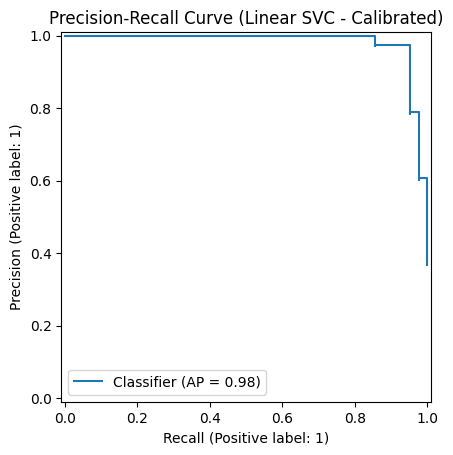

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import PrecisionRecallDisplay

# Buat pipeline dasar dengan StandardScaler dan LinearSVC
lin_raw = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LinearSVC(C=1.0, random_state=RSEED))
])

# Kalibrasi model menggunakan metode sigmoid
cal = CalibratedClassifierCV(lin_raw, method='sigmoid', cv=cv)

# Latih model terkalibrasi
cal.fit(X_tr, y_tr)

# Prediksi label dan probabilitas pada data test
yp = cal.predict(X_te)
proba = cal.predict_proba(X_te)[:, 1]

# Laporan hasil prediksi
print("Classification Report:")
print(classification_report(y_te, yp, target_names=['Benign', 'Malignant']))

# Visualisasi Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_te, proba)
plt.title("Precision-Recall Curve (Linear SVC - Calibrated)")
plt.show()

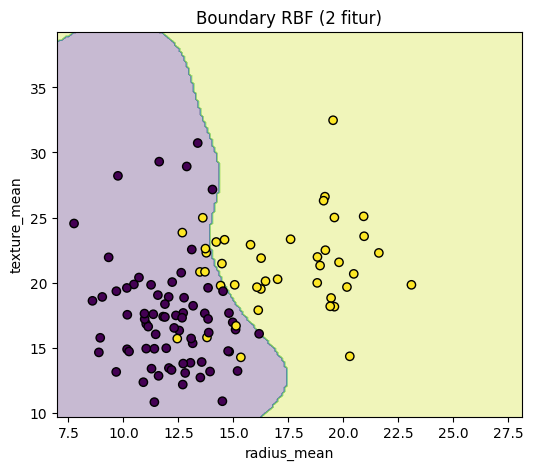

In [ ]:
cols = X.columns[:2]
from matplotlib.colors import ListedColormap

# Buat pipeline baru hanya dengan 2 fitur pertama
pipe2 = Pipeline([
    ('sc', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        C=best.named_steps['clf'].C,
        gamma=best.named_steps['clf'].gamma
    ))
])

# Latih model pada dua fitur
pipe2.fit(X_tr[cols], y_tr)

# Buat grid untuk plot decision boundary
x1 = np.linspace(X[cols[0]].min(), X[cols[0]].max(), 200)
x2 = np.linspace(X[cols[1]].min(), X[cols[1]].max(), 200)
xx1, xx2 = np.meshgrid(x1, x2)

# Prediksi setiap titik pada grid
Z = pipe2.predict(
    pd.DataFrame({
        cols[0]: xx1.ravel(),
        cols[1]: xx2.ravel()
    })
).reshape(xx1.shape)

# Plot hasil boundary
plt.figure(figsize=(6, 5))
plt.contourf(xx1, xx2, Z, alpha=0.3)
plt.scatter(X_te[cols[0]], X_te[cols[1]], c=y_te, edgecolor='k')
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.title('Boundary RBF (2 fitur)')
plt.show()